# path_joining

> Merging subpaths to form a longer continuous single line.

In [ ]:
#| default_exp stroke3.path_joining

In [ ]:
#| export
import copy

import numpy as np

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide

from fastcore.test import *
from IPython.display import SVG, display
from nbdev.showdoc import *

from singleline_dataset.stroke3.display_plot import *
from singleline_dataset.stroke3.display_svg import *
from singleline_dataset.stroke3.path_transforms import svg_to_strokes

## Joining Paths

When loading up an SVG and parsing its paths, sometimes the paths are segmented more than they need to be. For example:

../data/svg/0000.svg has 22 distinct strokes


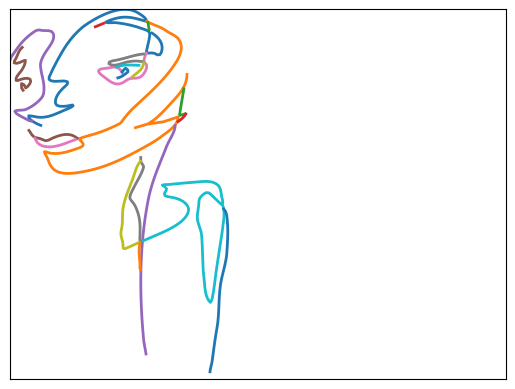

In [ ]:
fname = "../data/svg/0000.svg"
strokes = svg_to_strokes(fname)
print(f"{fname} has {len(strokes)} distinct strokes")
plot_strokes(strokes)

Taking a closer look at the first two strokes, it appears that they could be linked.

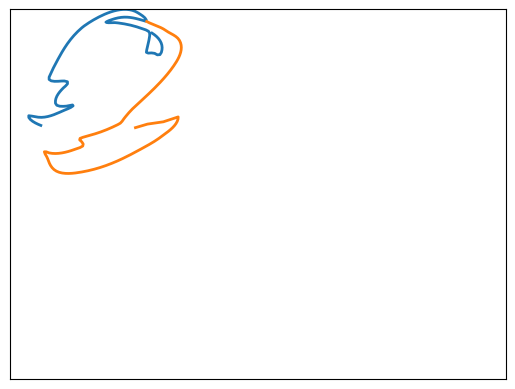

(array([[12.67485995, 64.03514953],
        [11.58004151, 63.41852999],
        [10.42656469, 62.66524592],
        [ 9.32611317, 61.78332364],
        [ 8.39037061, 60.78078948]]),
 145,
 array([[56.22437874,  6.67328336],
        [57.31087459,  7.40713502],
        [58.46074883,  8.07705417],
        [59.64263365,  8.71468671],
        [60.82516127,  9.35167852]]),
 155)

In [ ]:
plot_strokes([strokes[0], strokes[1]])
# glance at the underlying data and path lengths
strokes[0][:5], len(strokes[0]), strokes[1][:5], len(strokes[1])

What's not obvious yet is how to best join the strokes. Which endpoints of each line are closest?

Does the start of stroke 0 come closest to the end of stroke 1? If so, we'd concatenate the points of stroke 0 after the points of stroke 1.

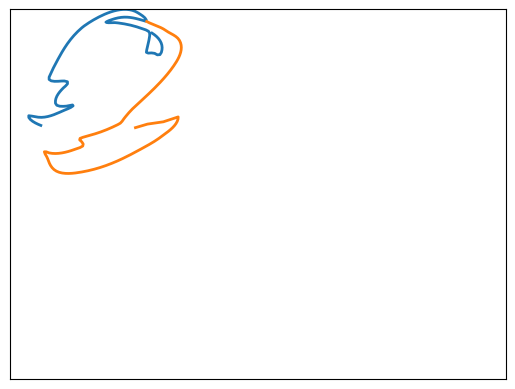

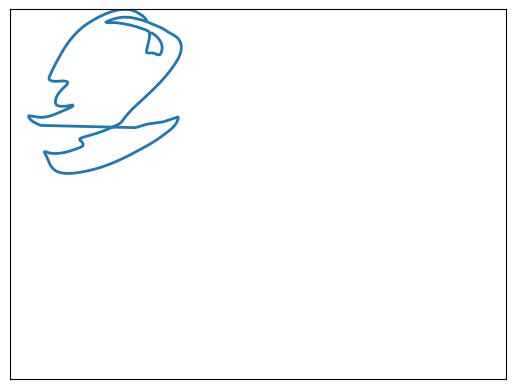

In [ ]:
plot_strokes([strokes[0], strokes[1]])
plot_strokes([np.concatenate([strokes[1], strokes[0]], axis=0)])

That didn't work - there's an awkward extra line that didn't show up in the original image.

Instead we can iterate through the combinations and find the combination of endpoints with the shortest distance.

In [ ]:
START = 0
END = -1
s0_endpoints = [
    strokes[0][0],
    strokes[0][-1],
]
s1_endpoints = [
    strokes[1][0],
    strokes[1][-1],
]

for pos0 in [START, END]:
    for pos1 in [START, END]:
        d = np.linalg.norm(s0_endpoints[pos0] - s1_endpoints[pos1])
        print(
            f"dist = {d} from s0_{'START' if pos0==START else 'END'} to s1_{'START' if pos1==START else 'END'}"
        )

dist = 72.02044347447433 from s0_START to s1_START
dist = 38.94401437099788 from s0_START to s1_END
dist = 6.7684841145897465 from s0_END to s1_START
dist = 52.632823136243246 from s0_END to s1_END


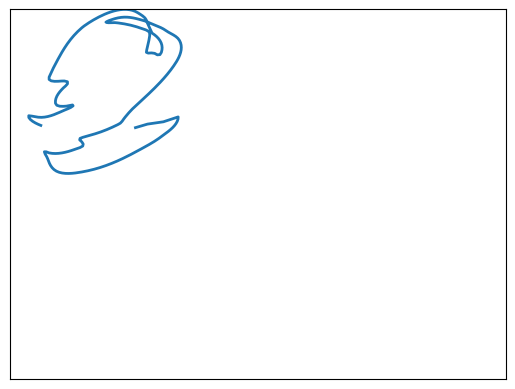

In [ ]:
plot_strokes([np.concatenate([strokes[0], strokes[1]], axis=0)])

We'll want a helper function to join these strokes - for example if the closest distance was between stroke 0 start and and stroke 1 start, we'd have to flip one of the lists in order to concatenate them and haave a contiguous set of points.

In [ ]:
#| export
def join_2_strokes(lhs, l_pos, rhs, r_pos):
    to_join = None
    if l_pos == START:
        if r_pos == START:
            to_join = [np.flip(rhs, axis=0), lhs]
        elif r_pos == END:
            to_join = [rhs, lhs]
        else:
            raise Exception(f"invalid r_pos: {r_pos}")
    elif l_pos == END:
        if r_pos == START:
            to_join = [lhs, rhs]
        elif r_pos == END:
            to_join = [lhs, np.flip(rhs, axis=0)]
        else:
            raise Exception(f"invalid r_pos: {r_pos}")
    else:
        raise Exception(f"invalid l_pos: {l_pos}")
    return np.concatenate(to_join, axis=0)

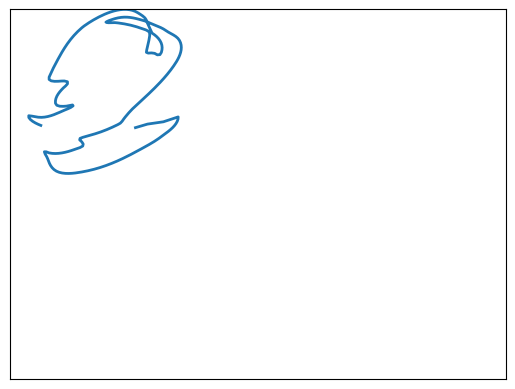

In [ ]:
plot_strokes([join_2_strokes(strokes[0], END, strokes[1], START)])

We'll want to apply this function iteratively to a collection of strokes. So we'll want to be able to pick 2 strokes out of the list, join them, and return them combined as a full list of strokes.

In [ ]:
#| export
def select_2_strokes(strokes, l_idx, r_idx):
    lhs = strokes[l_idx]
    rhs = strokes[r_idx]
    remaining = [x for i, x in enumerate(strokes) if i not in [l_idx, r_idx]]
    return lhs, rhs, remaining


def join_endpoints(strokes, l_idx, l_pos, r_idx, r_pos):
    lhs, rhs, remaining = select_2_strokes(strokes, l_idx, r_idx)
    joined = join_2_strokes(lhs, l_pos, rhs, r_pos)
    return [joined] + remaining

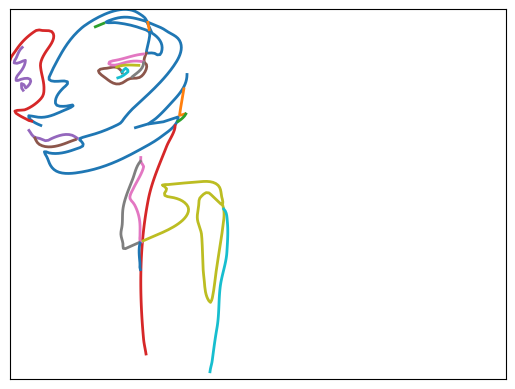

In [ ]:
# verify joining 2 strokes and adding them back to the list
plot_strokes(join_endpoints(strokes, 0, END, 1, START))

Now we'll want a way to find which pairs of strokes to join. Let's start by iterating through all pairs of strokes and comparing the distance between their start and endpoints.

In [ ]:
#| export
def closest_endpoint_pair(strokes):
    min_dist = 1e10
    l_idx = None
    r_idx = None
    l_pos = None
    r_pos = None

    for i, lhs in enumerate(strokes):
        for j, rhs in enumerate(strokes):
            if i == j:
                continue

            l0_r0_dist = np.linalg.norm(lhs[START] - rhs[START])
            l0_r1_dist = np.linalg.norm(lhs[START] - rhs[END])
            l1_r0_dist = np.linalg.norm(lhs[END] - rhs[START])
            l1_r1_dist = np.linalg.norm(lhs[END] - rhs[END])

            # print(i, len(c), (l0_r0_dist, l0_r1_dist, l1_r0_dist, l1_r1_dist))

            if l0_r0_dist < min_dist:
                min_dist = l0_r0_dist
                l_idx = i
                r_idx = j
                l_pos = START
                r_pos = START
            if l0_r1_dist < min_dist:
                min_dist = l0_r1_dist
                l_idx = i
                r_idx = j
                l_pos = START
                r_pos = END
            if l1_r0_dist < min_dist:
                min_dist = l1_r0_dist
                l_idx = i
                r_idx = j
                l_pos = END
                r_pos = START
            if l1_r1_dist < min_dist:
                min_dist = l1_r1_dist
                l_idx = i
                r_idx = j
                l_pos = END
                r_pos = END
    return min_dist, l_idx, l_pos, r_idx, r_pos

In [ ]:
actual_dist, l_idx, l_pos, r_idx, r_pos = closest_endpoint_pair(strokes)
print(actual_dist, l_idx, l_pos, r_idx, r_pos)

expected_lhs = strokes[l_idx][l_pos]
expected_rhs = strokes[r_idx][r_pos]
expected_dist = np.linalg.norm(expected_lhs - expected_rhs)
print(expected_dist)

test_eq(actual_dist, expected_dist)

0.40342377522616846 12 -1 13 0
0.40342377522616846


In [ ]:
#| export
def merge_closest_strokes(strokes, dist_threshold=10.0):
    sorted_strokes = sorted(strokes, key=lambda s: len(s), reverse=True)

    min_dist, min_l_idx, min_l_pos, min_r_idx, min_r_pos = closest_endpoint_pair(
        sorted_strokes
    )

    print(f"Minimum distance: {min_dist}")
    print(f"From {min_l_idx}_{min_l_pos} ({len(strokes[min_l_idx])} points)")
    print(f"To {min_r_idx}_{min_r_pos} ({len(strokes[min_l_idx])} points)")

    if min_dist >= dist_threshold:
        print("not merging")
        return min_dist, strokes

    return min_dist, join_endpoints(
        sorted_strokes, min_l_idx, min_l_pos, min_r_idx, min_r_pos
    )

In [ ]:
_, new_strokes = merge_closest_strokes(strokes)

# the list of strokes should be shorter by 1, since 2 strokes got merged
test_eq(len(strokes) - 1, len(new_strokes))

# the next closest distance should be different than what we got before,
# as that gap between lines no longer exists post-merge.
new_dist, *_ = closest_endpoint_pair(new_strokes)
test_ne(actual_dist, new_dist)

# Also if that was the shortest gap between points, the next distance we
# get will be larger.
test_eq(True, new_dist > actual_dist)

Minimum distance: 0.40342377522616846
From 14_-1 (97 points)
To 19_0 (97 points)


In [ ]:
#| export
def merge_until(strokes, dist_threshold=10.0):
    curr_strokes = copy.copy(strokes)
    all_iterations = [curr_strokes]
    for i in range(len(curr_strokes)):
        min_dist, curr_strokes = merge_closest_strokes(
            curr_strokes, dist_threshold=dist_threshold
        )
        print(f"[{i}] - len(curr_strokes) = {len(curr_strokes)}, min_dist = {min_dist}")
        if min_dist > dist_threshold:
            print("exceeded dist threshold")
            break
        all_iterations.append(curr_strokes)
    print(
        f"finished merging - len(curr_strokes) = {len(curr_strokes)}, min_dist = {min_dist}"
    )
    return curr_strokes, all_iterations

In [ ]:
r0, r_iter = merge_until(strokes, dist_threshold=10)
len(r0), [len(r) for r in r_iter]

Minimum distance: 0.40342377522616846
From 14_-1 (97 points)
To 19_0 (97 points)
[0] - len(curr_strokes) = 21, min_dist = 0.40342377522616846
Minimum distance: 0.5023185486414509
From 6_-1 (67 points)
To 15_0 (67 points)
[1] - len(curr_strokes) = 20, min_dist = 0.5023185486414509
Minimum distance: 0.5138644417789598
From 11_0 (24 points)
To 16_0 (24 points)
[2] - len(curr_strokes) = 19, min_dist = 0.5138644417789598
Minimum distance: 0.5492710411450011
From 8_-1 (38 points)
To 15_0 (38 points)
[3] - len(curr_strokes) = 18, min_dist = 0.5492710411450011
Minimum distance: 0.6894214938226391
From 1_0 (157 points)
To 16_0 (157 points)
[4] - len(curr_strokes) = 17, min_dist = 0.6894214938226391
Minimum distance: 0.7294996802981244
From 1_0 (157 points)
To 8_-1 (157 points)
[5] - len(curr_strokes) = 16, min_dist = 0.7294996802981244
Minimum distance: 1.1019618435623961
From 12_-1 (19 points)
To 13_-1 (19 points)
[6] - len(curr_strokes) = 15, min_dist = 1.1019618435623961
Minimum distance: 1.

(5, [22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5])

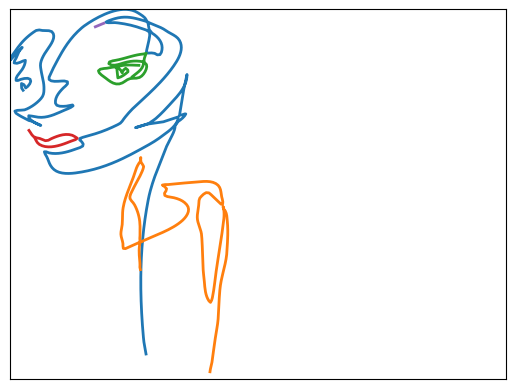

In [ ]:
plot_strokes(r0)

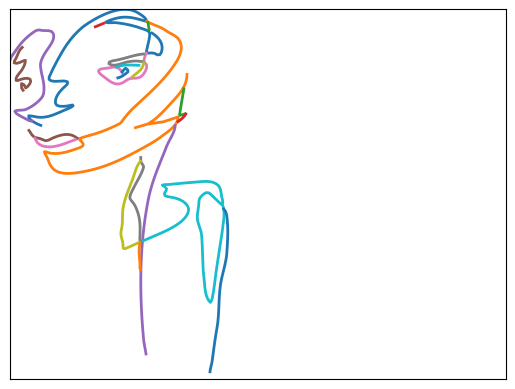

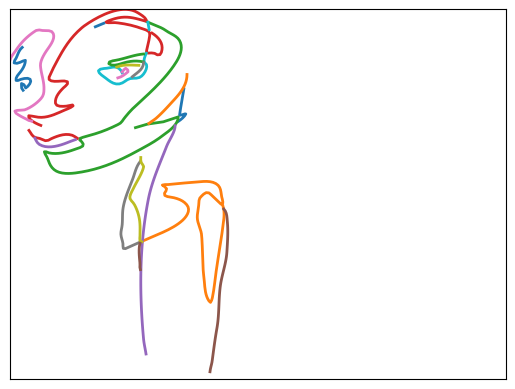

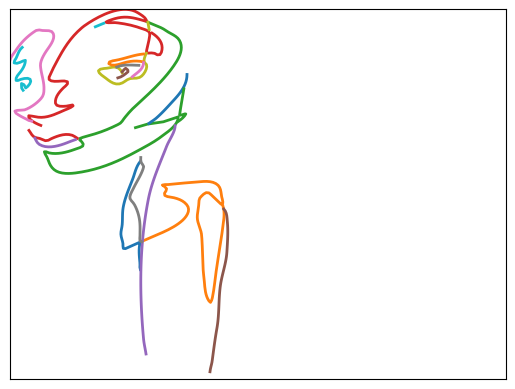

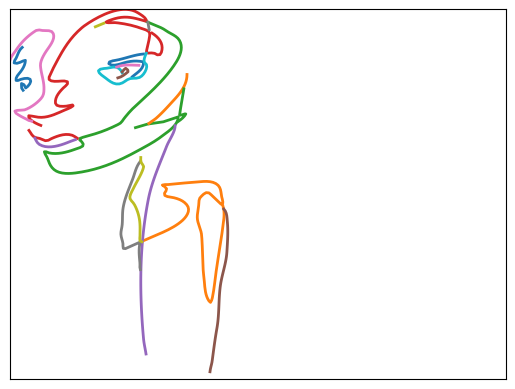

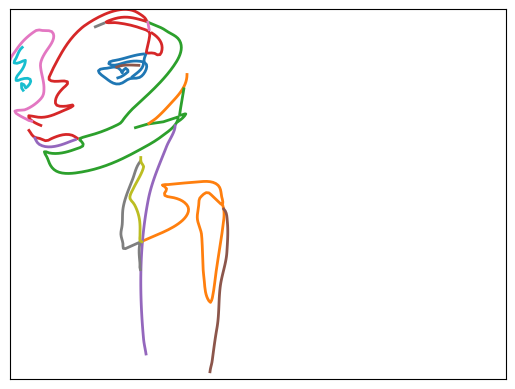

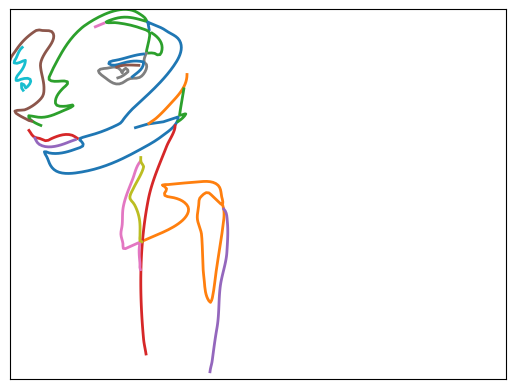

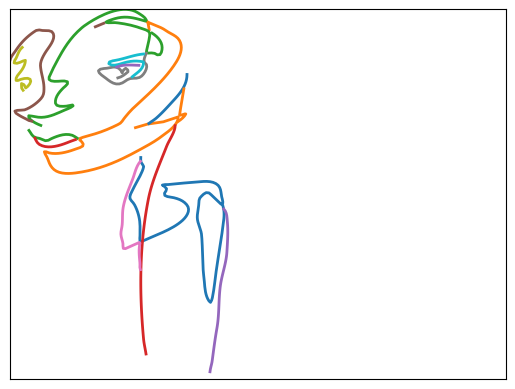

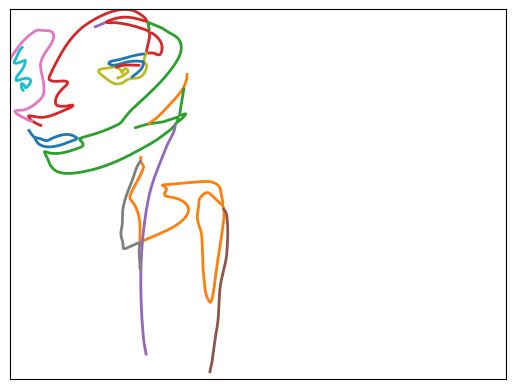

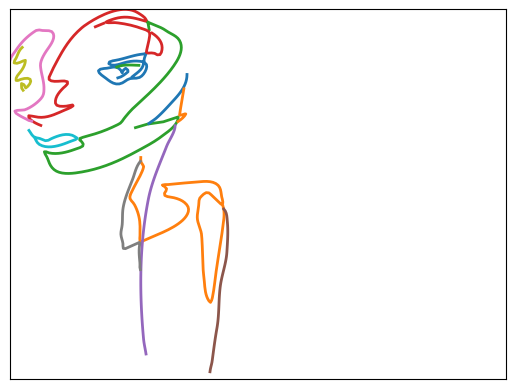

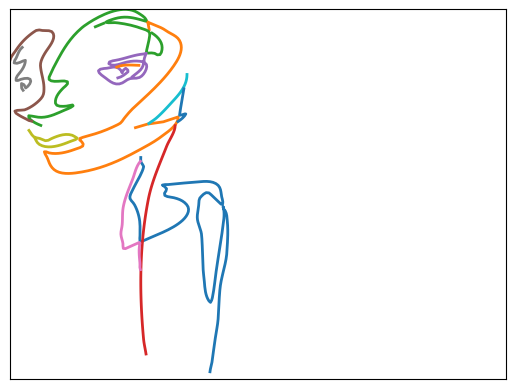

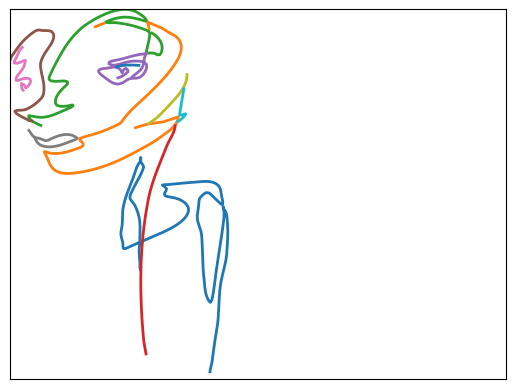

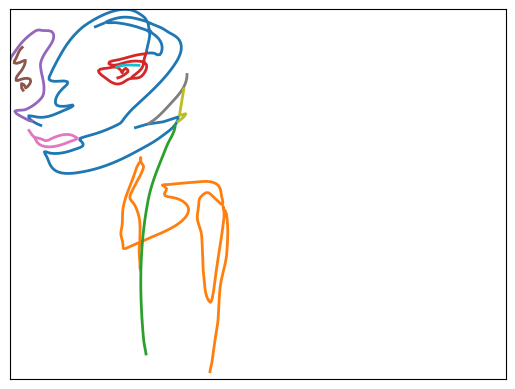

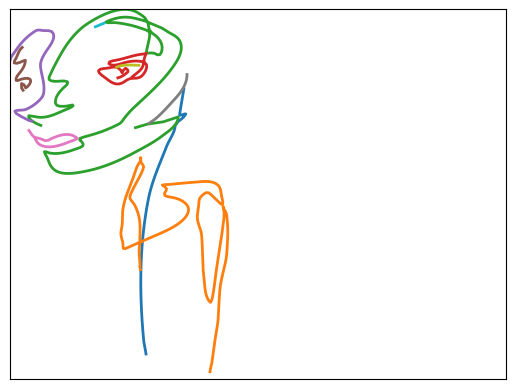

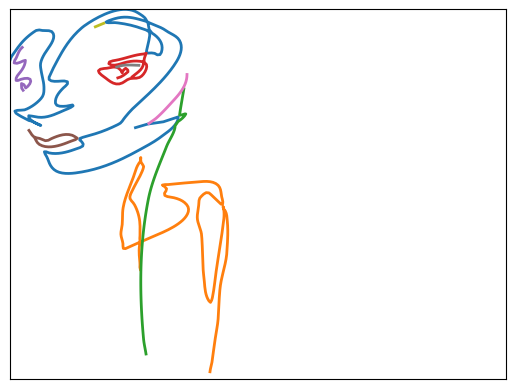

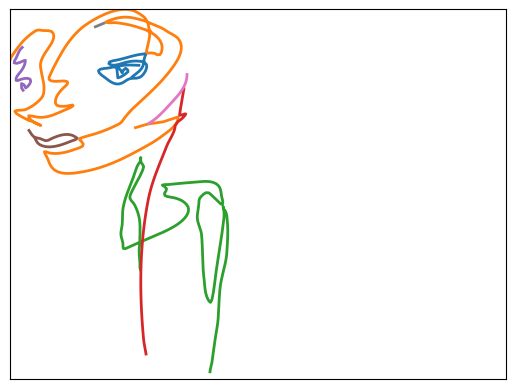

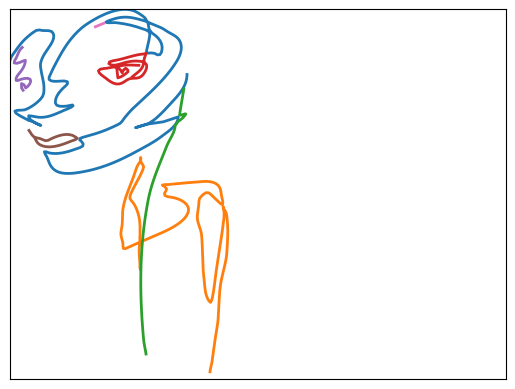

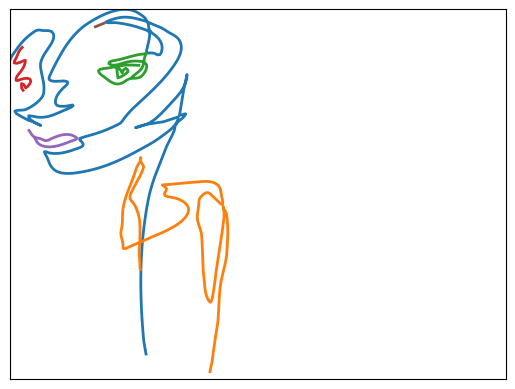

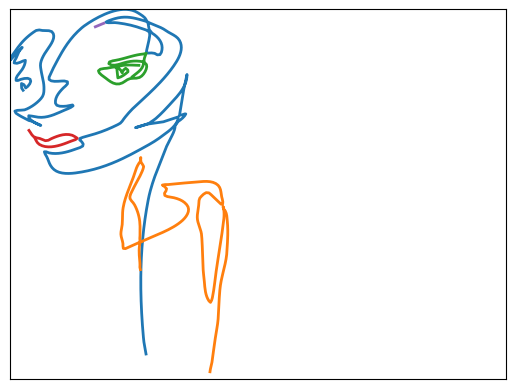

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
[plot_strokes(r) for r in r_iter]

In [ ]:
def closest_splice_pair(strokes):
    min_dist = 1e10
    l_idx = None
    r_idx = None
    r_sub = None

    for i, lhs in enumerate(strokes):
        lhs_start = lhs[START]
        lhs_end = lhs[END]
        # print(f"LHS {i}: {lhs_start}, {lhs_end}")

        for j, rhs in enumerate(strokes):
            # print(f"\tRHS {j}")
            if i == j:
                continue
            for k in range(len(rhs)-1):
                l0_r0_dist = np.linalg.norm(lhs_start - rhs[k])
                l1_r0_dist = np.linalg.norm(lhs_end - rhs[k])

                total_dist = l0_r0_dist + l1_r0_dist
                # print(f"\t\tRHS {j} pos {k} - total_dist={total_dist}")

                if total_dist < min_dist:
                    min_dist = total_dist
                    l_idx = i
                    r_idx = j
                    r_sub = k

    return min_dist, l_idx, r_idx, r_sub

In [ ]:
#| export
def splice_2_strokes(lhs, rhs, k):
    return np.concatenate([rhs[:k], lhs, rhs[k:]], axis=0)

def join_splice(strokes, l_idx, r_idx, k):
    lhs, rhs, remaining = select_2_strokes(strokes, l_idx, r_idx)
    joined = splice_2_strokes(lhs, rhs, k)
    return [joined] + remaining

#| export
def splice_until(strokes, dist_threshold=10.0):
    curr_strokes = copy.copy(strokes)
    all_iterations = [curr_strokes]
    for i in range(len(curr_strokes)):
        min_dist, min_l_idx, min_r_idx, k = closest_splice_pair(curr_strokes)

        curr_strokes = join_splice(curr_strokes, min_l_idx, min_r_idx, k)

        print(f"Minimum distance: {min_dist}")
        print(f"From {min_l_idx} ({len(strokes[min_l_idx])} points)")
        print(f"To {min_r_idx} ({len(strokes[min_l_idx])} points)")
        print(f"At index k={k}")

        if min_dist > dist_threshold:
            print("exceeded dist threshold")
            break
        all_iterations.append(curr_strokes)
    print(
        f"finished merging - len(curr_strokes) = {len(curr_strokes)}, min_dist = {min_dist}"
    )
    return curr_strokes, all_iterations

In [ ]:
r1, r1_iter = splice_until(r0, 30.0)

Minimum distance: 6.072497711032335
From 4 (4 points)
To 0 (4 points)
At index k=209
Minimum distance: 12.791936638626382
From 3 (35 points)
To 0 (35 points)
At index k=104
Minimum distance: 22.35007242383534
From 2 (86 points)
To 0 (86 points)
At index k=272
Minimum distance: 63.29543814391407
From 1 (320 points)
To 0 (320 points)
At index k=637
exceeded dist threshold
finished merging - len(curr_strokes) = 1, min_dist = 63.29543814391407


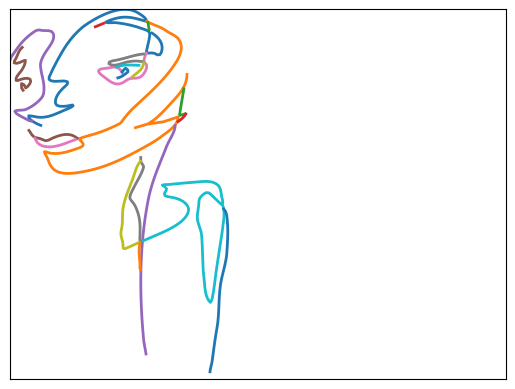

In [ ]:
plot_strokes(strokes)

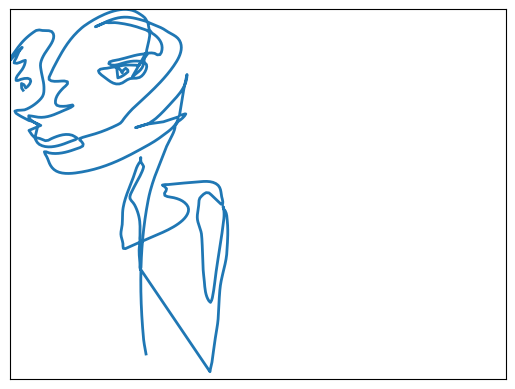

In [ ]:
plot_strokes(r1)

In [ ]:
len(r1)

1

In [ ]:
len(r1[0])

993

In [ ]:
create_animation(r1, fname='../assets/path_splice.mp4')
show_video('../assets/path_splice.mp4')

993


In [ ]:
closest_splice_pair(r0[:3])

LHS 0: [ 5.39224878 44.65315115], [ 55.94341456 190.18882592]
	RHS 0
	RHS 1
		RHS 1 pos 0 - total_dist=156.72239377208297
		RHS 1 pos 1 - total_dist=156.77146255511187
		RHS 1 pos 2 - total_dist=156.92331744357827
		RHS 1 pos 3 - total_dist=157.04629977534313
		RHS 1 pos 4 - total_dist=157.14845103133254
		RHS 1 pos 5 - total_dist=157.25819533974266
		RHS 1 pos 6 - total_dist=157.37957582187454
		RHS 1 pos 7 - total_dist=157.51679254383015
		RHS 1 pos 8 - total_dist=157.67426487481453
		RHS 1 pos 9 - total_dist=157.85671240341333
		RHS 1 pos 10 - total_dist=158.0692513377506
		RHS 1 pos 11 - total_dist=158.31750420835522
		RHS 1 pos 12 - total_dist=158.2448010153189
		RHS 1 pos 13 - total_dist=157.6627930594331
		RHS 1 pos 14 - total_dist=157.1220257884384
		RHS 1 pos 15 - total_dist=156.62315481269607
		RHS 1 pos 16 - total_dist=156.166824519187
		RHS 1 pos 17 - total_dist=155.75366534102898
		RHS 1 pos 18 - total_dist=155.521721912144
		RHS 1 pos 19 - total_dist=155.59365431819117
		

(22.35007242383534, 2, 0, 233)

In [ ]:
len(r1)

3

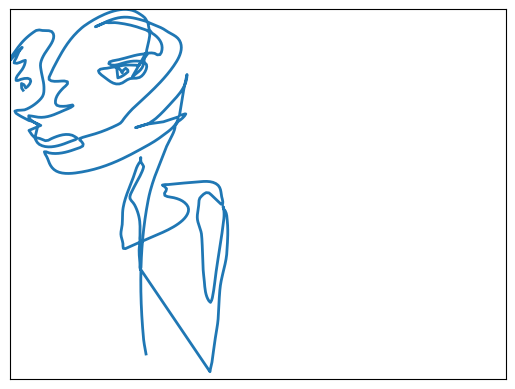

In [ ]:
plot_strokes(r1)

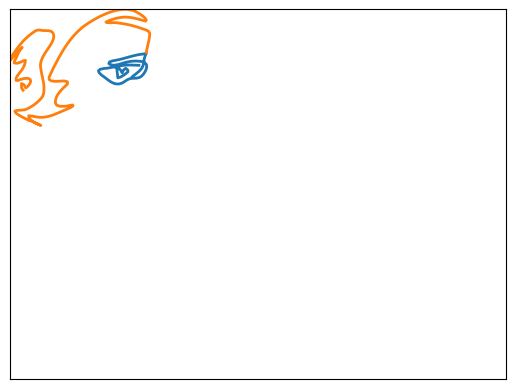

In [ ]:
plot_strokes([r0[2], r0[0][:233]])

In [ ]:
new_dist, *_ = closest_endpoint_pair(new_strokes)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import animation


# def animate_path_join_iterations(
#     strokes_iterations, fname="../assets/path_join.mp4", fps=60, target_size=200, lw=2, trailing_frames=30
# ):
#     seq_length = np.vstack(strokes).shape[0]
#     total_frames = len(strokes_iterations) * seq_length

#     # First set up the figure, the axis, and the plot element we want to animate
#     fig = plt.figure()
#     ax = plt.axes(xlim=(0, target_size + 2 * lw), ylim=(-target_size - 2 * lw, 0))
#     ax.set_facecolor("white")
    
#     (line,) = ax.plot([], [], lw=lw)
#     # lines = []
#     # for s in strokes_iterations[0]:
#     #     (line,) = ax.plot([], [], lw=lw)
#     #     #line.set_data(s[:, 0], -s[:, 1])
#     #     lines.append(line)

#     # remove the axis
#     ax.grid = False
#     ax.set_xticks([])
#     ax.set_yticks([])

#     i = 0
#     j = 0
#     k = 0

#     # initialization function: plot the background of each frame
#     def init():
#         line.set_data([], [])
#         # for line in lines:
#         #     line.set_data([], [])
#         # return (line,)

#     # animation function.  This is called sequentially
#     def animate(frame):
#         nonlocal i, j, k, line
#         lines = []
#         if k < len(strokes_iterations):
#             strokes = strokes_iterations[k]
#         if i < len(strokes_iterations):
#             strokes = strokes_iterations[i]
#             # for idx, s in enumerate(strokes):
#                 line = lines[idx]
#                 x = s[:, 0]
#                 y = -s[:, 1]
#                 line.set_data(x[:j], y[:j])
#                 # lines.append(line)
#         if frame % frames_per_iter == 0:
#             i += 1

#         return lines
#         # nonlocal i, j, line
#         # if i < len(strokes):
#         #     x = strokes[i][:, 0]
#         #     y = strokes[i][:, 1]
#         #     line.set_data(x[0:j], -y[0:j])

#         #     if j >= len(x):
#         #         i += 1
#         #         j = 0
#         #         (line,) = ax.plot([], [], lw=lw)
#         #     else:
#         #         j += 1
#         # else:
#         #     # if i has already incremented past all the strokes,
#         #     # that means this is a "trailing frame" (meant to leave
#         #     # the finished drawing onscreen for a moment).
#         #     pass
#         # return (line,)

#     # call the animator.  blit=True means only re-draw the parts that have changed.
#     anim = animation.FuncAnimation(
#         fig, animate, init_func=init, frames=total_frames, blit=True
#     )
#     plt.close()

#     # save the animation as an mp4.
#     anim.save(fname, fps=fps, extra_args=["-vcodec", "libx264"])

In [ ]:
# from singleline_dataset.stroke3.display_plot import show_video

# animate_path_join_iterations(r_iter, "../assets/path_join.mp4")
# show_video("../assets/path_join.mp4")

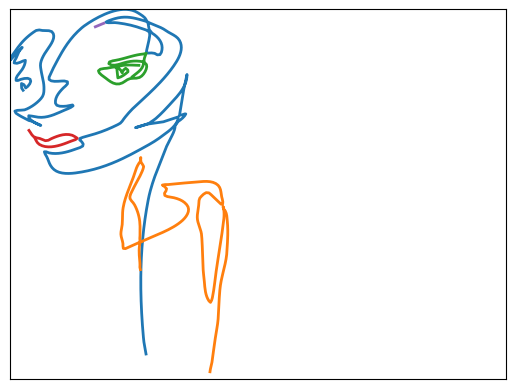

In [ ]:
plot_strokes(r0)

In [ ]:
strokes[[0, 5]][1].shape

(36, 2)

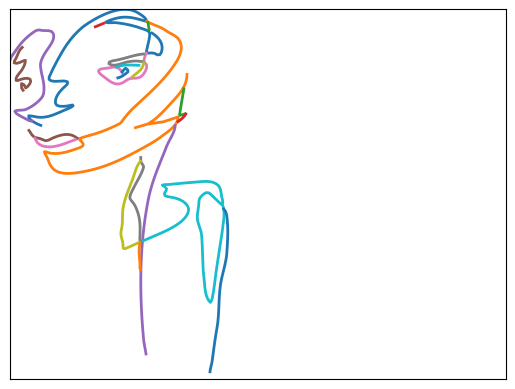

In [ ]:
plot_strokes(rescaled_strokes)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()